**OBJECTIVE:** To assess ViMuRe models on the 75 villages of Karnataka data.

**LAST UPDATED:** 27/12/2021



**Change these values to run a different village+layer**

In [1]:
village = "vil55"
layer = "visit"

In [2]:
import os
import tqdm

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import vimure as vm

from plotnine import * 
from mizani.formatters import percent_format

from vimure.log import setup_logging
logger = setup_logging("notebook04-single-run")

In [3]:
# https://stackoverflow.com/a/59812588/843365
!export PYTHONUNBUFFERED=1

In [4]:
COLORS =  ['#E69F25', '#5CB4E4', '#069F72', '#F1E545', '#0773B2', '#CC79A8']

In [5]:
def custom_reciprocity_scoring_fixed_threshold(model, threshold=None):
    Y_rec = vm.utils.apply_rho_threshold(model, threshold)
    return vm.utils.calculate_overall_reciprocity(Y_rec[0])

# Data Input

Read villages as `vm.io.BaseNetwork` objects, convenient for our model usage.

If you want to revise or modify the pre-processing, modify functions directly on `experiments.karnataka.py`

In [6]:
from experiments.karnataka import read_village_data, parse_village

DATA_FOLDER = "../data/input/india_microfinance/formatted/"  # Folder contains structured CSV files

networks = parse_village(village, data_folder=DATA_FOLDER)
networks

/mnt/code/vimure/io.py:212: UserWarning: Reporters Mask was not informed (parameter R). Parser will build it from reporter column, assuming a reporter can only report their own ties.
/mnt/code/vimure/io.py:279: UserWarning: Parameter K was None. Defaulting to: 2


{'advice': <vimure.io.RealNetwork at 0x7ff8b0a79310>,
 'kerorice': <vimure.io.RealNetwork at 0x7ff8b0a79ac0>,
 'money': <vimure.io.RealNetwork at 0x7ff8b0a79070>,
 'visit': <vimure.io.RealNetwork at 0x7ff8b0a79b20>}

**SELECTED LAYER**

In [7]:
network = networks[layer]
reporters = set(network.R.subs[3])
nrv = set(np.arange(network.N)) - reporters

print(f"N : {network.N}")
print(f"M : {network.M}")
print(f"Number of reporters according to R tensor: {len(reporters)} (must match M)")
print(f"Number of non-respondents: {len(nrv)} (must match N - M)")
print(f"Number of ties reported: {network.X.vals.sum()}")

N : 575
M : 279
Number of reporters according to R tensor: 279 (must match M)
Number of non-respondents: 296 (must match N - M)
Number of ties reported: 1973


# Calculate Baseline

## Union

In [8]:
sumX = np.sum(network.X.toarray(), axis=3)
X_union = np.zeros(sumX.shape).astype("int")
X_union[sumX > 0] = 1

# Only keep within sample
X_union = X_union[0]
X_union = X_union[list(reporters),:]
X_union = X_union[:, list(reporters)]

G_union = nx.from_numpy_matrix(X_union, create_using=nx.DiGraph)

## Intersection

In [9]:
X_intersection = np.zeros(sumX.shape).astype("int")
X_intersection[sumX == 2] = 1

# Only keep within sample
X_intersection = X_intersection[0]
X_intersection = X_intersection[list(reporters),:]
X_intersection = X_intersection[:, list(reporters)]

G_intersection = nx.from_numpy_matrix(X_intersection, create_using=nx.DiGraph)

# Baseline network statistics

In [10]:
def calculate_net_stats(name, G):
    
    # Avg number of nominations (outgoing edges) per reporter
    out_degrees = [d for _, d in G.out_degree()]
    avg_out_degree = np.mean(out_degrees)
    std_out_degree = np.std(out_degrees)
    
    
    return pd.DataFrame({"num_edges":       G.number_of_edges(),
                         "avg_out_degree":  f"$ {avg_out_degree:.2f} \pm {std_out_degree:.2f}$",
                         "transitivity" :   f"{nx.transitivity(G):.2f}",
                         "reciprocity"  :   f"{nx.overall_reciprocity(G):.2f}"
                        },
                        index=[name])


graphs = {"union": G_union,
          "intersection": G_intersection}

net_stats_df = pd.concat([calculate_net_stats(name, g) for name, g in graphs.items()])
net_stats_df

,num_edges,avg_out_degree,transitivity,reciprocity
union,878,$ 3.15 \pm 1.92$,0.17,0.93
intersection,147,$ 0.53 \pm 0.72$,0.18,0.88


# Run Vimure - Single run

## Constants

In [11]:
NUM_REALISATIONS = 5
MAX_ITER = 100
SEED = 1

## Running algorithm 

In [12]:
model = vm.model.VimureModel(mutuality=True, undirected=False, verbose=True)

model.fit(X=network.X,
          R=network.R,
          K=2,
          seed=SEED,
          num_realisations=NUM_REALISATIONS,
          max_iter=MAX_ITER)

2021-12-27 16:20:57,666 - [PID 1057] - vm.model.VimureModel      - DEBUG - Checking user parameters passed to the VimureModel.fit()
2021-12-27 16:20:57,894 - [PID 1057] - vm.model.VimureModel      - DEBUG - Initializing priors
2021-12-27 16:20:57,895 - [PID 1057] - vm.model.VimureModel      - DEBUG - Setting priors on rho
2021-12-27 16:20:59,207 - [PID 1057] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter    1 | ELBO value: -3759.624513175750 | Reached convergence: False
2021-12-27 16:21:04,806 - [PID 1057] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter   10 | ELBO value: 1025.769863886571 | Reached convergence: False
2021-12-27 16:21:10,941 - [PID 1057] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter   20 | ELBO value: 1051.604695705566 | Reached convergence: False
2021-12-27 16:21:17,132 - [PID 1057] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter   30 | ELBO value: 1058.054212001637 | Reached convergence: False
2021-12-27 16:21:23,267

VimureModel()

# Diagnostics

In [13]:
diag_obj = vm.diagnostics.Diagnostics(model, network)
diag_obj

---------------
- DIAGNOSTICS -
---------------

Model: ViMuRe(T)

  Priors:
   - eta:    shp=0.50 rte=1.00
   - theta:  shp=0.10 rte=0.10
   - lambda: shp=10.0 rte=10.0
   - rho:    a (1, 575, 575, 2) tensor (to inspect it, run <diag_obj>.model.pr_rho)

  Posteriors:
   - G_exp_lambda_f: [[7.23761693e-05 4.19067347e-01]]
   - G_exp_nu_f: 0.89
   - G_exp_theta_f: a (1, 575) tensor (to inspect it, run <diag_obj>.model.G_exp_theta_f)
   - rho_f: a (1, 575, 575, 2) tensor (to inspect it, run <diag_obj>.model.rho_f)

Optimisation:

   Elbo: 1061.300071697152

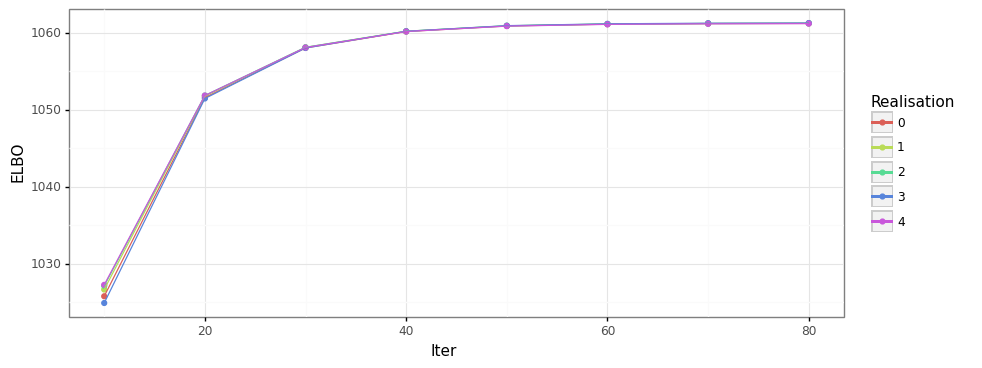

<ggplot: (8794171410170)>

In [14]:
diag_obj.plot_elbo_values()

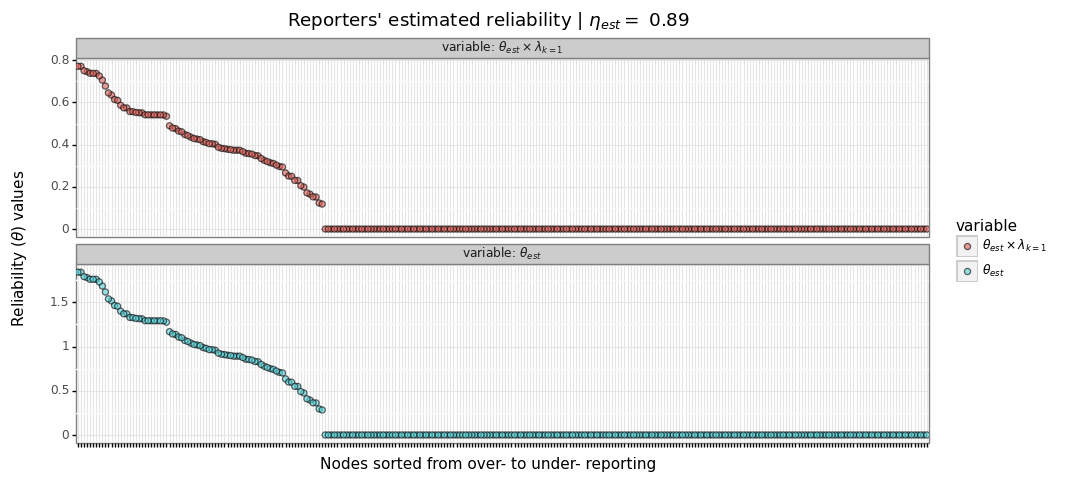

<ggplot: (8794171695092)>

In [15]:
g = diag_obj.plot_theta(return_node_order=False, remove_nodes=map(str, nrv))

g

In [16]:
print(f"Reciprocity X (union)         = {vm.utils.calculate_overall_reciprocity(X_union):.3f}")
print(f"Reciprocity X (intersection)  = {vm.utils.calculate_overall_reciprocity(X_intersection):.3f}") 

print()

print(r"Reciprocity ViMuRe(T)         = %.3f (threshold on rho = %.3f)" % (custom_reciprocity_scoring_fixed_threshold(model), 
                                                                           vm.utils.get_optimal_threshold(model)))

Reciprocity X (union)         = 0.934
Reciprocity X (intersection)  = 0.884

Reciprocity ViMuRe(T)         = 0.867 (threshold on rho = 0.472)


# Export files for further insepction

## Model Details

In [17]:
df_model_details = pd.DataFrame(
                        {
                            "num_realisations": model.num_realisations,
                            "max_iter": model.max_iter,
                            "initial_seed": SEED,
                            "best_seed": model.seed,
                            "best_elbo": model.maxL,
                            "eta_est": model.G_exp_nu,
                            "lambda_k": model.G_exp_lambda_f.tolist(),
                            "model": "ViMuRe_T",
                            "village": village,
                            "layer": layer
                        }, index=[0]
                    )


df_model_details

,num_realisations,max_iter,initial_seed,best_seed,best_elbo,eta_est,lambda_k,model,village,layer
0,5,100,1,967,1061.300072,0.892274,"[7.237616929627185e-05, 0.41906734687373387]",ViMuRe_T,vil55,visit


## Model Trace

In [18]:
df_trace = model.trace
df_trace["model"] = "ViMuRe_T"
df_trace["village"] = village
df_trace["layer"] = layer
df_trace

,realisation,seed,iter,elbo,runtime,reached_convergence,model,village,layer
0,0,1,10,1025.769864,0.611085,False,ViMuRe_T,vil55,visit
1,0,1,20,1051.604696,0.585433,False,ViMuRe_T,vil55,visit
2,0,1,30,1058.054212,0.586063,False,ViMuRe_T,vil55,visit
3,0,1,40,1060.191165,0.592051,False,ViMuRe_T,vil55,visit
4,0,1,50,1060.910478,0.650087,False,ViMuRe_T,vil55,visit
5,0,1,60,1061.146236,0.573386,False,ViMuRe_T,vil55,visit
6,0,1,70,1061.222249,0.586068,False,ViMuRe_T,vil55,visit
7,0,1,80,1061.246957,0.585327,True,ViMuRe_T,vil55,visit
8,1,175,10,1026.647857,0.570182,False,ViMuRe_T,vil55,visit
9,1,175,20,1051.790536,0.566159,False,ViMuRe_T,vil55,visit


## Edgelist with reliability columns

In [19]:
sumX = np.sum(network.X.toarray(), axis=3)
X_union = np.zeros(sumX.shape).astype("int")
X_union[sumX > 0] = 1

X_intersection = np.zeros(sumX.shape).astype("int")
X_intersection[sumX == 2] = 1

Y_vimure = vm.utils.apply_rho_threshold(model)

df_edgelist = pd.Series({(l,i,j): {"village"                      : village,
                                   "layer"                        : layer,
                                   "source"                       : i,
                                   "target"                       : j,
                                   "dyad_ID"                      : f"{i}_{j}",
                                   "source_reliability"           : model.G_exp_lambda_f[l, 1] * model.G_exp_theta_f[l, i],
                                   "target_reliability"           : model.G_exp_lambda_f[l, 1] * model.G_exp_theta_f[l, j],
                                   "source_report"                : np.array(network.X[l,i,j,i]).flatten()[0] == 1,
                                   "target_report"                : np.array(network.X[l,i,j,j]).flatten()[0] == 1,
                                   "vimure_posterior_probability" : model.rho_f[l,i,j,1],
                                   "in_union"                     : X_union[l,i,j] == 1,
                                   "in_intersection"              : X_intersection[l,i,j] == 1,
                                   "in_vimure"                    : Y_vimure[l,i,j] == 1,
                                   "reciprocated_in_union"        : X_union[l,j,i] == 1,
                                   "reciprocated_in_intersection" : X_intersection[l,j,i] == 1,
                                   "reciprocated_in_vimure"       : Y_vimure[l,j,i] == 1
                                   }
                         for l in range(model.rho_f.shape[0]) 
                         for i in range(model.rho_f.shape[1]) 
                         for j in range(model.rho_f.shape[2])}, name="stats")
df_edgelist = pd.DataFrame(df_edgelist.values.tolist())

# Only keep dyads that are in union, intersection or ViMuRe
df_edgelist = df_edgelist[(df_edgelist["in_union"] | 
                           df_edgelist["in_intersection"] | 
                           df_edgelist["in_vimure"])].copy()

In [20]:
df_edgelist

,village,layer,source,target,dyad_ID,source_reliability,target_reliability,source_report,target_report,vimure_posterior_probability,in_union,in_intersection,in_vimure,reciprocated_in_union,reciprocated_in_intersection,reciprocated_in_vimure
31,vil55,visit,0,31,0_31,0.000009,0.000125,True,False,0.491176,True,False,True,True,False,True
332,vil55,visit,0,332,0_332,0.000009,0.294187,True,False,0.402348,True,False,False,True,False,False
459,vil55,visit,0,459,0_459,0.000009,0.000125,True,False,0.490859,True,False,True,True,False,True
725,vil55,visit,1,150,1_150,0.000005,0.230114,True,False,0.407795,True,False,False,True,True,True
802,vil55,visit,1,227,1_227,0.000005,0.000125,True,False,0.496946,True,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329994,vil55,visit,573,519,573_519,0.000004,0.000004,True,False,0.493614,True,False,True,True,False,True
330197,vil55,visit,574,147,574_147,0.000008,0.000005,True,False,0.488664,True,False,True,True,False,True
330250,vil55,visit,574,200,574_200,0.000008,0.586740,True,False,0.329963,True,False,False,True,False,False
330265,vil55,visit,574,215,574_215,0.000008,0.000125,True,False,0.492425,True,False,True,True,False,True


In [21]:
pd.crosstab(df_edgelist["source_report"], df_edgelist["target_report"], normalize=True)*100

target_report,False,True
source_report,,
False,0.000000,45.509310
True,46.440307,8.050383


In [22]:
pd.crosstab(df_edgelist["reciprocated_in_union"], df_edgelist["reciprocated_in_vimure"], normalize=True)*100

reciprocated_in_vimure,False,True
reciprocated_in_union,,
False,8.652793,0.000000
True,28.368018,62.979189


In [23]:
df_reliability = pd.Series(
    {
        (ll, m): {
            "village": village,
            "layer": layer,
            "node": m,
            "theta": model.G_exp_theta_f[ll, m],
            "lambda_theta": model.G_exp_lambda_f[ll, 1] * model.G_exp_theta_f[ll, m],
            "is_node_reporter": m in reporters,
        }
        for ll in range(model.R.shape[0])
        for m in range(model.R.shape[1])  # Because N == M
    },
    name="stats",
)
df_reliability = pd.DataFrame(df_reliability.values.tolist())
df_reliability.head()

,village,layer,node,theta,lambda_theta,is_node_reporter
0,vil55,visit,0,0.000022,0.000009,True
1,vil55,visit,1,0.000012,0.000005,True
2,vil55,visit,2,0.000011,0.000005,True
3,vil55,visit,3,0.000297,0.000125,False
4,vil55,visit,4,0.000013,0.000006,True


# Radial Plots

In [24]:
labels = ["conf_give_to", "conf_get_from", "not_conf_give_to_alter", "not_conf_get_from_alter", "not_conf_give_to_ego", "not_conf_get_from_ego"]
colors = ['forestgreen', 'lightgreen', 'indianred', 'lightsalmon', 'dodgerblue', 'skyblue']

def reliability_interactions(rep_id, 
                             network,
                             reliabilities_df, 
                             verbose=False, 
                             undirected=False):
    
    l, i, j, m = network.X.subs
    ties_reported_by_rep_id = np.argwhere(m == rep_id).flatten()
    
    rep_in_deg  = np.argwhere(j[ties_reported_by_rep_id] == rep_id).size
    rep_out_deg = np.argwhere(i[ties_reported_by_rep_id] == rep_id).size
    
    rep_theta = reliabilities_df[(reliabilities_df["node"]    == rep_id)]["lambda_theta"].values[0]
    
    if verbose:
        print(f'Reporter id {rep_id}')
        print(f'\ntheta(rep_id): {rep_theta}')
        if undirected:
            print(f'Reported Degree: {rep_in_deg}')
        else:
            print(f'Reported In-degree: {rep_in_deg} -- Reported Out-degree: {rep_out_deg}')

    #######################################################
    # EGO : Incoming and outgoing ties reported by rep_id #
    #######################################################
    id_incoming_ties = ties_reported_by_rep_id[np.argwhere(j[ties_reported_by_rep_id] == rep_id)].flatten()
    id_outgoing_ties = ties_reported_by_rep_id[np.argwhere(i[ties_reported_by_rep_id] == rep_id)].flatten()
    
    ego_get_from_ = set(i[id_incoming_ties]) 
    if not undirected:
        ego_give_to_ = set(j[id_outgoing_ties])
        if len(ego_get_from_.union(ego_give_to_)) > 0:
            ind_rec = len(ego_get_from_.intersection(ego_give_to_)) / len(ego_get_from_.union(ego_give_to_))
        else:
            ind_rec = 0.
    if verbose:
        if not undirected:
            print(f'Individual reciprocity: {ind_rec:.2}')
        print(f'\nNominated subjects:')
        if undirected:
            print(f'\tego: {len(ego_get_from_)}')
        else:
            print(f'\tego_give_to : {len(ego_give_to_)} \n\tego_get_from: {len(ego_get_from_)}')

    ################################################################################
    # ALTERS : Incoming and outgoing ties of rep_id as reported by other reporters #
    ################################################################################
    
    ties_NOT_reported_by_rep_id = (m != rep_id)
    
    id_incoming_ties = np.argwhere(np.logical_and(j == rep_id, ties_NOT_reported_by_rep_id)).flatten()
    id_outgoing_ties = np.argwhere(np.logical_and(i == rep_id, ties_NOT_reported_by_rep_id)).flatten()
    
    alter_give_to_ = set(j[id_outgoing_ties])
    if not undirected:
        alter_get_from_ = set(i[id_incoming_ties])

    conf_get_from = len(ego_get_from_.intersection(alter_give_to_))
    not_conf_get_from_alter = len(ego_get_from_.difference(alter_give_to_))
    not_conf_get_from_ego = len(alter_give_to_.difference(ego_get_from_))
    if not undirected:
        conf_give_to = len(ego_give_to_.intersection(alter_get_from_))
        not_conf_give_to_alter = len(ego_give_to_.difference(alter_get_from_))
        not_conf_give_to_ego = len(alter_get_from_.difference(ego_give_to_))

    if verbose:
        print(f'\nGet nominated:')
        # print(f'Number of people who claim to get help from: {len(alter_get_from_)}')
        # print(f'Number of people who claim to give help to: {len(alter_give_to_)}')
        if undirected:
            print(f'\tConfirmed relationships: {conf_get_from}')
            print(f'\tNot confirmed (by alter): {not_conf_get_from_alter}')
            print(f'\tNot nominated (by ego): {not_conf_get_from_ego}')
        else:
            print(f'\tConfirmed relationships for give_to: {conf_give_to}')
            print(f'\tConfirmed relationships for get_from: {conf_get_from}')
            print(f'\tNot confirmed ego_give_to (by alter): {not_conf_give_to_alter}')
            print(f'\tNot confirmed ego_get_from (by alter): {not_conf_get_from_alter}')
            print(f'\tNot nominated ego_give_to (by ego): {not_conf_give_to_ego}')
            print(f'\tNot nominated ego_get_from (by ego): {not_conf_get_from_ego}')

    if undirected:
        toreturn = {'rep_id': rep_id,
                    'rep_theta': rep_theta,
                    'conf_get_from': conf_get_from, 
                    'not_conf_get_from_alter': not_conf_get_from_alter, 
                    'not_conf_get_from_ego': not_conf_get_from_ego}
    else:
        toreturn = {'rep_id': rep_id,
                    'rep_theta': rep_theta,
                    'conf_give_to': conf_give_to, 
                    'conf_get_from': conf_get_from, 
                    'not_conf_give_to_alter': not_conf_give_to_alter, 
                    'not_conf_get_from_alter': not_conf_get_from_alter, 
                    'not_conf_give_to_ego': not_conf_give_to_ego, 
                    'not_conf_get_from_ego': not_conf_get_from_ego}

    return toreturn

In [25]:
def radial_plots(selected_reporters, village, layer, network, reliabilities_df=df_reliability):

    plt.figure(figsize=(16,4))
    maxval = 6
    l = 0

    pie_values = np.linspace(0.0, 2 * np.pi, 6, endpoint=False)
    width = (2*np.pi) / 6

    for subplot_id, rep_id in enumerate(selected_reporters):
        values_rec = reliability_interactions(rep_id, 
                                              network=network, 
                                              reliabilities_df=reliabilities_df[(reliabilities_df["village"] == village) & (reliabilities_df["layer"] == layer)])
        rep_theta = values_rec["rep_theta"]

        values_rec = list(values_rec.values())[2:]

        ax = plt.subplot(151 + subplot_id, polar=True)
        bars = ax.bar(pie_values, values_rec, width=width, bottom=0, align='edge')
        ax.xaxis.set_ticks(pie_values)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticks(np.arange(0, maxval, 1)[1:])
        title = 'Node %s \n' % rep_id
        title += r'$G[\hat{\theta}]$ = ' 
        title += '%.2f' % (rep_theta)
        ax.set_title(title)
        for r, bar in enumerate(bars):
            bar.set_facecolor(colors[r])
            bar.set_alpha(0.6)
            bar.set_label(labels[r])

    plt.legend(loc=[1.2, 0.265])
    # plt.margins(0.015, tight=True)
    # plt.savefig("/mnt/data/output/real_data/nicaragua/nicaragua_example_reports.pdf", dpi=300, bbox_inches = "tight")

    plt.show()

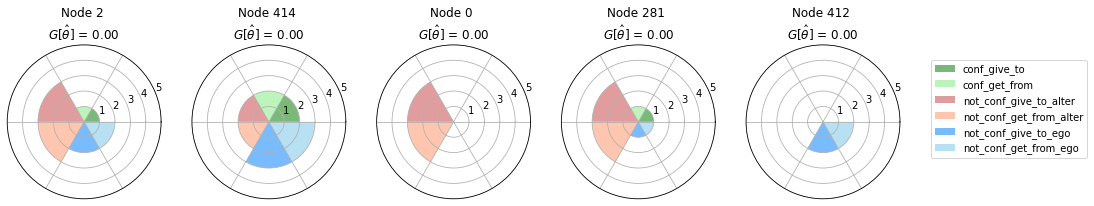

In [28]:
radial_plots(selected_reporters = [2, 414,  0, 281, 412],
             network=network,
             village = "vil55", layer = "visit")